# Matrix method check

In [2]:
import numpy as np
import sys
sys.path.append('../../../../')
import matrixmethod as mm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']

## Solving structure for displacements

In [21]:
EI = 36100
EI2 = 36100*np.sqrt(13)
EA = 40000000000
GA = 0
F = 616
q1 = 0
q2 = 0

mm.Node.clear()
mm.Element.clear()

nodes = []
elems = []

nodes.append(mm.Node(0,0))
nodes.append(mm.Node(3,-2))
nodes.append(mm.Node(6,-2))
nodes.append(mm.Node(9,-2))
nodes.append(mm.Node(9,2))

elems.append(mm.Element(nodes[0],nodes[1]))
elems.append(mm.Element(nodes[1],nodes[2]))
elems.append(mm.Element(nodes[2],nodes[3]))
elems.append(mm.Element(nodes[3],nodes[4]))

nodes[2].add_load([0,F,0],nodal_load=True)

con = mm.Constrainer()
con.fix_dof(nodes[0],0)
con.fix_dof(nodes[0],1)
con.fix_dof(nodes[4],0)
con.fix_dof(nodes[4],1)

In [22]:
# general

section = {}
section['EA'] = EA
section['EI'] = EI

for elem in elems:
    elem.set_section(section)

section['EI'] = EI2
elems[0].set_section(section)
    

global_k = np.zeros ((3*len(nodes), 3*len(nodes)))
global_f = np.zeros (3*len(nodes))

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

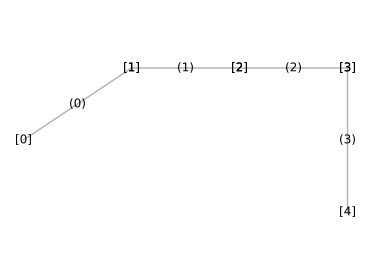

In [23]:
for i, elem in enumerate(elems):
    elem.plot_numbered_structure(i)

In [24]:
Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )

u_full = con.full_disp(u_free)

In [25]:
import pandas as pd

# Reshape the u_full array into a 3-column table
table_data = pd.DataFrame(np.array(u_full).reshape(-1, 3), columns=['$u_x$', '$u_z$','$\phi$'])

#round the values in this table to three decimal places
#table_data = table_data.round(3)

# Convert the table data to a Markdown table
markdown_table = table_data.to_markdown(index=True)

#add '> ' to the beginning of each line to make it a comment in markdown
markdown_table = '> ' + markdown_table.replace('\n', '\n> ')

# Print the Markdown table
print(markdown_table)


> |    |   $u_x$ |     $u_z$ |     $\phi$ |
> |---:|--------:|----------:|-----------:|
> |  0 |    0    | 0         | -0.0207479 |
> |  1 |    0.04 | 0.06      | -0.0185042 |
> |  2 |    0.04 | 0.0744391 |  0.0158379 |
> |  3 |    0.04 | 4.485e-08 |  0.0151524 |
> |  4 |    0    | 0         | -0.0225762 |


## Postprocessing

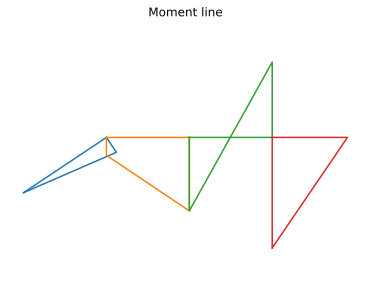

In [32]:
for elem in elems:
    elem.plot_moment_diagram (u_full[elem.global_dofs()], num_points=50, global_c=True, scale=0.004)

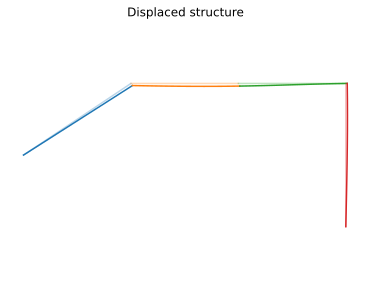

In [27]:
for elem in elems:
    elem.plot_displaced (u_full[elem.global_dofs()], num_points=10, global_c=True, scale=1)

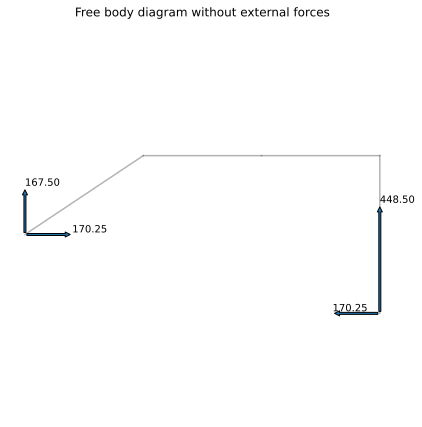

In [28]:
support_reactions = con.support_reactions(global_k,u_free,global_f)
con.plot_free_body_diagram(nodes,elems,support_reactions,scale=5)

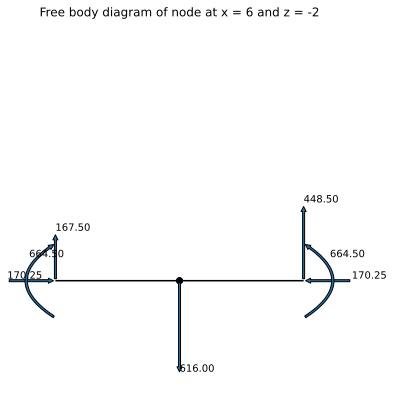

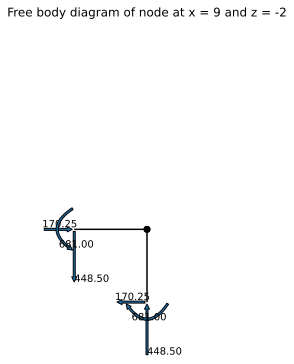

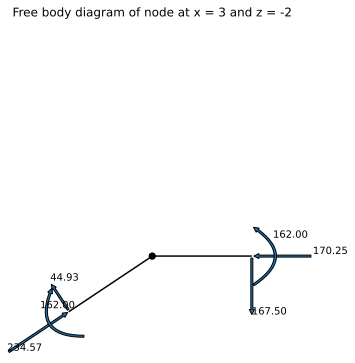

In [33]:
nodes[2].plot_FBD(elems, nodes, con, u_full, support_reactions)
nodes[3].plot_FBD(elems, nodes, con, u_full, support_reactions)
nodes[1].plot_FBD(elems, nodes, con, u_full, support_reactions)